# Advanced VQE: Quantum Subspace Expansion

*References: https://arxiv.org/abs/1603.05681, https://arxiv.org/abs/1707.06408, https://arxiv.org/abs/1807.10050*

The VQE algorithm exhibits a "natural" robustness against errors, especially regarding $\vec{\theta}^\star$, the optimal value of the parameter. Unfortunately, the energy evalutation (i.e. mean-value measurement) can still suffer from important errors. 

McClean *et al.* drew inspiration from *Linear Response Theory* to design an extension to the VQE, the *Quantum Subspace Expansion* (QSE). The core idea is to expand the Hamiltonian post-VQE on a well-chosen subspace (i.e. where an improved, lower, energy lies) and solve classically the associated generalized eigenvalue problem with the hope of getting an improved value for the ground state energy.

More precisely, the QSE can be split into different steps:
1. Choice of qubit operators;
2. Expansion of the Hamiltonian on the subspace defined by the two previous choices; Construction of the overlap matrix;
3. Resolution of the generalized eigenvalue problem.

Thus, the $n$-qubit QSE using $G$ as the chosen set of $n$-qubit operators, is associated  with the following state subspace:
$$
    \{ \hat{\sigma}|\psi^\star\rangle, \qquad \hat{\sigma} \in G \}
$$
where $|\psi^\star\rangle = |\mathrm{UCC}(\vec{\theta}^\star)\rangle$ is the output of the VQE.

The expanded Hamiltonian and overlap matrices, $(H_{i, j})$ and $(S_{i, j})$, are then measured *via* a quantum computer, i.e.
$$
    H_{i, j} = \langle \psi^\star | \hat{\sigma}_i^\dagger \hat{H} \hat{\sigma}_j | \psi^\star\rangle \qquad
    S_{i, j} = \langle \psi^\star | \hat{\sigma}_i^\dagger \hat{\sigma}_j | \psi^\star\rangle
$$

Finally, the associated generalized eigenvalue problem is solved classically and the minimal solution is extracted, i.e.
$$
    E_{\mathrm{QSE}} = \min\{E, \qquad H \vec{x} = E S \vec{x}\}
$$


## Part 1: Problem definition and UCC preparation

In [1]:
import numpy as np

nels = 2
one_body_integrals = np.array([[-1.25246357, 0], [0, -0.475948715]])
two_body_integrals = np.array(
    [
        [[[0.674488766, 0], [0, 0.181288808]], [[0, 0.181288808], [0.663468096, 0]]],
        [[[0, 0.663468096], [0.181288808, 0]], [[0.181288808, 0], [0, 0.697393767]]],
    ]
)
orbital_energies = np.array([-0.57797481, 0.66969867])
nuclear_repulsion = 0.7137539936876182

## the natural-orbital occupation numbers (NOONs) are computed from 1-RDM (computed in CISD here)
noons = np.array([1.9745399697399246, 0.025460030260075376])

# If you have installed the pySCF module, you can use the following lines of code to perform
# the quantum-chemistry part of the computation
# import numpy as np
# from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

# geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.7414))]
# basis = 'sto-3g'

# rdm1, orbital_energies, nuclear_repulsion,\
# nels, one_body_integrals, two_body_integrals, info = perform_pyscf_computation(geometry=geometry, basis=basis, spin=0,
#                                                                               charge=0, verbose=True)
## get NOONs from 1-RDM (computed in CISD)
# noons = list(reversed(sorted(np.linalg.eigvalsh(rdm1))))

### UCC preparation

In [2]:
%load_ext autoreload
%autoreload 2

from qat.fermion.chemistry.ucc_deprecated import (
    get_cluster_ops_and_init_guess,
    get_active_space_hamiltonian,
)

H_active, active_inds, occ_inds = get_active_space_hamiltonian(
    one_body_integrals, two_body_integrals, noons, nels, nuclear_repulsion
)

active_noons, active_orb_energies = [], []
for ind in active_inds:
    active_noons.extend([noons[ind], noons[ind]])
    active_orb_energies.extend([orbital_energies[ind], orbital_energies[ind]])
nb_active_els = nels - 2 * len(occ_inds)
cluster_ops, theta_0, hf_init = get_cluster_ops_and_init_guess(nb_active_els, active_noons, active_orb_energies, H_active.hpqrs)

/home/moliva/.local/lib/python3.9/site-packages/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "
/usr/local/lib64/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
/tmp/ipykernel_697427/1579706526.py:18: UserWarning: This guess_init_state function is deprecated.
  cluster_ops, theta_0, hf_init = get_cluster_ops_and_init_guess(nb_active_els, active_noons, active_orb_energies, H_active.hpqrs)


### Transformation to qubit space

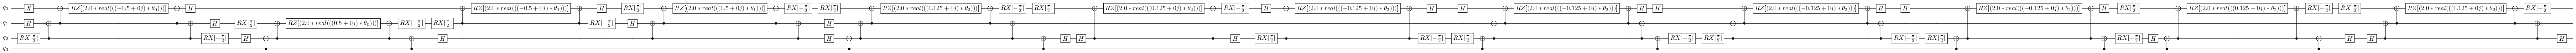

In [3]:
from qat.fermion.transforms import recode_integer
from qat.fermion.transforms import transform_to_bk_basis, get_bk_code
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code
from qat.fermion.transforms import transform_to_parity_basis, get_parity_code


# transformation, code = transform_to_bk_basis, get_bk_code
# transformation, code = transform_to_jw_basis, get_jw_code
transformation, code = transform_to_parity_basis, get_parity_code

H_active_sp = transformation(H_active)
nqbits = H_active_sp.nbqbits

# T-> Tspin
# cluster_ops_sp = {k: transformation(t_o) for k, t_o in cluster_ops.items()}
cluster_ops_sp = [transformation(t_o) for t_o in cluster_ops]

# ket -> ketspin
hf_init_sp = recode_integer(hf_init, code(nqbits))

##Finally: build_uccsd
from qat.fermion.chemistry.ucc import construct_ucc_ansatz

prog = construct_ucc_ansatz(cluster_ops_sp, hf_init_sp)
circ = prog.to_circ()

circ.display()

## Part 2: Definition of the noise model

In [4]:
# Noisy QPU construction:
from qat.quops import ParametricPureDephasing, ParametricAmplitudeDamping
from qat.hardware import HardwareModel, DefaultGatesSpecification
from qat.noisy import NoisyQProc

gate_durations = {
    "H": 50,
    "X": 50,
    "RY": lambda angle: 200,
    "RX": lambda angle: 200,
    "RZ": lambda angle: 200,
    "CNOT": 500,
    "PH": lambda angle: 200,
}

ibm_gates_spec = DefaultGatesSpecification(gate_durations)

T1, T2 = 800000, 800000  # nanosecs

amp_damping = ParametricAmplitudeDamping(T_1=T1)
pure_dephasing = ParametricPureDephasing(T_phi=1 / (1 / T2 - 1 / (2 * T1)))
qpu = NoisyQProc(
    hardware_model=HardwareModel(ibm_gates_spec, idle_noise=[amp_damping, pure_dephasing]),
    sim_method="deterministic-vectorized",
)

## Part 3: VQE optimization

Let us first compute the exact ground state energy:

In [5]:
eigvals = np.linalg.eigvalsh(H_active_sp.get_matrix())
E_min = min(eigvals)
print("E_min (exact diagonalization) = %s" % (E_min))

E_min (exact diagonalization) = -1.1372701679265034


### Minimizing with COBYLA

In [6]:
from qat.plugins import ScipyMinimizePlugin

optimizer_scipy = ScipyMinimizePlugin(method="COBYLA", tol=1e-3, options={"maxiter": 1000}, x0=theta_0)
stack = optimizer_scipy | qpu
res = stack.submit(circ.to_job(job_type="OBS", observable=H_active_sp))
theta_VQE = res.meta_data["parameters"]
print("Optimal theta (VQE): %s" % theta_VQE)
print("E (VQE) = %s (err = %s %%)" % (res.value, 100 * abs((res.value - E_min) / E_min)))

Optimal theta (VQE): [0.00035223212483659973, -0.0006637896680429512, 0.11280159941309813]
E (VQE) = -1.1124494950559185 (err = 2.182478145526184 %)


### Minimizing with SPSA
Let us try with an alternative optimizer:

In [7]:
from qat.plugins import SPSAMinimizePlugin

optimizer_spsa = ScipyMinimizePlugin(x0=theta_0)
stack = optimizer_spsa | qpu

res = stack.submit(circ.to_job(job_type="OBS", observable=H_active_sp))
theta_VQE = res.meta_data["parameters"]
print("Optimal theta (VQE): %s" % theta_VQE)
print("E (VQE) = %s (err = %s %%)" % (res.value, 100 * abs((res.value - E_min) / E_min)))
e_vqe = res.value

Optimal theta (VQE): [0.0, 0.0, 0.112999455569726]
E (VQE) = -1.112449916656354 (err = 2.1824410742613836 %)


## Part 4: Quantum subspace expansion

In [8]:
from qat.fermion import Hamiltonian
from qat.core import Term

expansion_operators = [
    Hamiltonian(nqbits, [], 1.0),
    Hamiltonian(nqbits, [Term(1.0, "ZZ", [0, 1])]),
]

from qat.fermion.chemistry.qse import apply_quantum_subspace_expansion

# we use the optimal parameters found by VQE
opt_circ = circ.bind_variables(eval(res.meta_data["parameter_map"]))

e_qse = apply_quantum_subspace_expansion(H_active_sp, opt_circ, expansion_operators, qpu, return_matrices=False)
print("E(QSE) = %s (err = %s %%)" % (e_qse, 100 * abs((e_qse - E_min) / E_min)))

E(QSE) = -1.1210320445832729 (err = 1.4278158173124513 %)


Notice how the error decreased between VQE and QSE.